## Convert SyMBac data to be compatible with Omnipose

In [28]:
from glob import glob
import os
import random
from PIL import Image 
from skimage.morphology import label
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage.util import img_as_ubyte
np.random.seed(4)

Load in the directories for the masks and convolutions (synthetic images)

In [42]:
SyMBac_training_data_dir = "training_data_full"
savedir = "omnipose_SyMBac_TD"

In [12]:
masks_dir = SyMBac_training_data_dir + "/masks/"
convs_dir = SyMBac_training_data_dir + "/convolutions/"
masks = sorted(glob(masks_dir+"/*"))
convs = sorted(glob(convs_dir+"/*")) 

Grab the shape of one of the images

In [14]:
img_shape = tifffile.imread(masks[0]).shape
print(img_shape)

(256, 46)


Omnipose trains well and more efficiently on tiles of images. We will generate training_data of size `tile_length` for this purpose. You will have generated many training samples using SyMBac, maybe >1000. Omnipose trains well on small datasets, and is also slow to train compared to DeLTA for the same number of images. Therefore we will sample (without replacement) indices from the existing training data, and concatengate adjacent frames.

In [41]:
tile_length = 40
training_samples = 200
indices = random.sample(range(len(masks)-tile_length), training_samples)
label_required = False # If you did not use label=True in SyMBac, then you should set this to true.

Generate the training data

In [39]:
os.mkdir(savedir)
for i, x in enumerate(indices):
    x = indices[i]
    mask_tile = np.concatenate([tifffile.imread(mask) for mask in masks[x:x+tile_length]], axis=1)
    if label_required:
        mask_tile = label(mask_tile)    
    conv_tile = np.concatenate([tifffile.imread(conv) for conv in convs[x:x+tile_length]], axis=1)
    conv_tile = conv_tile/conv_tile.max()
    conv_tile = img_as_ubyte(conv_tile)
    Image.fromarray(mask_tile.astype(np.ubyte)).save(f"{savedir}/train_{str(i).zfill(5)}_masks.png")
    Image.fromarray(conv_tile).save(f"{savedir}/train_{str(i).zfill(5)}.png")

Visualise the last two training samples

Text(0.5, 1.0, 'Synthetic data')

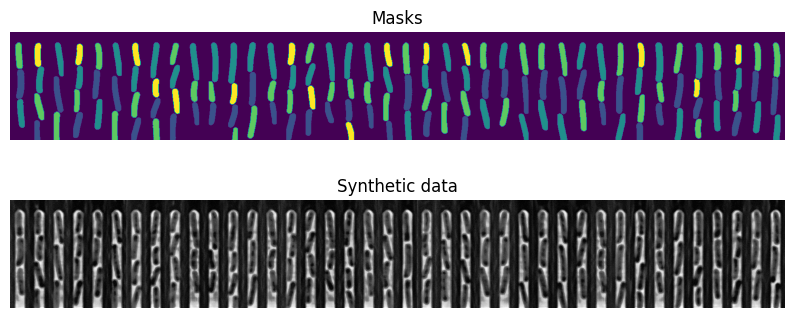

In [53]:
fig, axs = plt.subplots(2, figsize=(10,4))
axs[0].imshow(mask_tile)
axs[1].imshow(conv_tile, cmap="Greys_r")
for ax in axs:
    ax.axis("off")
axs[0].set_title("Masks")
axs[1].set_title("Synthetic data")

## Training Omnipose

You can then train omnipose by running the following command, which is the same one as given in the Omnipose GitHub repository.

```
python -m omnipose --train --use_gpu --dir SyMBac_training_data_dir --mask_filter "_masks" --n_epochs 4000 --pretrained_model None --save_every 100 --save_each --learning_rate 0.1 --diameter 0 --batch_size 16
```

This will train for 4000 epochs and save a model every 100 epochs.